# Assignment 7

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings

warnings.filterwarnings("ignore")

In [2]:
df_insuarance = pd.read_csv('/home/theuri/Documents/ADS/Assignment 7/insurance.csv')
df_insuarance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
df_insuarance.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [4]:
df_insuarance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Considering the target column is continous in nature, a regression approach is requred in conducting predictive analysis on the data.

<AxesSubplot:ylabel='Frequency'>

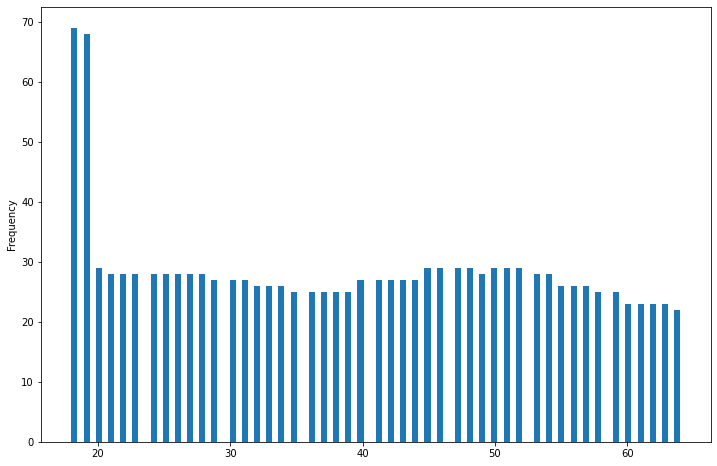

In [5]:
df_insuarance['age'].plot(kind = 'hist', figsize = (12, 8), bins = 100)

Majority of the individuals captured in the data are below 20 years of age. As from 30 to 70 years of age, there was a balance of the individuals in the data.

In [6]:
numerical_continuous = []
for column in df_insuarance.columns:
    if df_insuarance[column].dtypes != 'object':
        if df_insuarance[column].nunique() >= 10:
            numerical_continuous.append(column)
numerical_continuous.remove('charges')
numerical_continuous

['age', 'bmi']

In [7]:
numerical_discrete = []
for column in df_insuarance.columns:
    if df_insuarance[column].dtypes != 'object':
        if df_insuarance[column].nunique() < 10:
            numerical_discrete.append(column)
numerical_discrete

['children']

<AxesSubplot:>

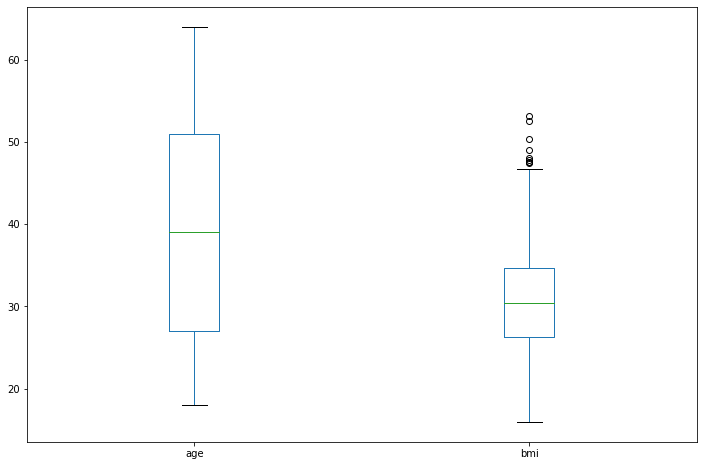

In [8]:
df_insuarance[numerical_continuous].plot(kind = 'box', figsize = (12, 8))

<AxesSubplot:>

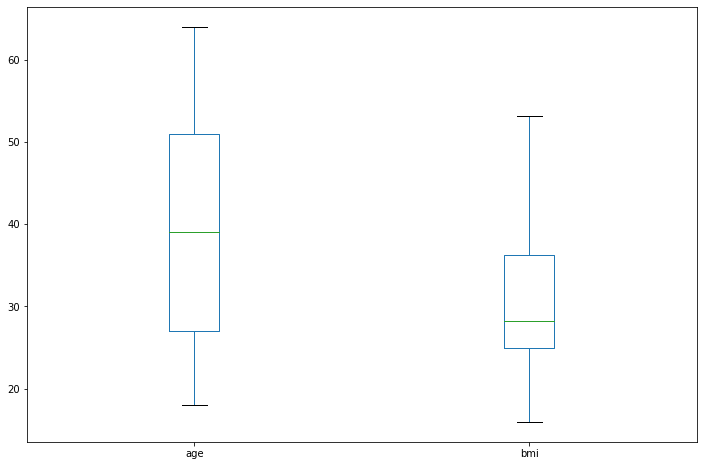

In [9]:
threshold = 0.3705
zscore = np.abs(stats.zscore(df_insuarance[['bmi']]))
df_insuarance[(zscore > threshold).all(axis=1)][numerical_continuous].plot(kind = 'box', figsize = (12, 8))

In [10]:
df_insuarance = df_insuarance[(zscore > threshold).all(axis = 1)]

In [11]:
categorical = []
for column in df_insuarance.columns:
    if df_insuarance[column].dtypes == 'object':
        categorical.append(column)
categorical

['sex', 'smoker', 'region']

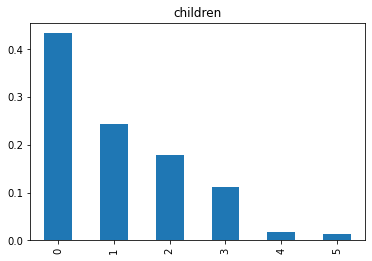

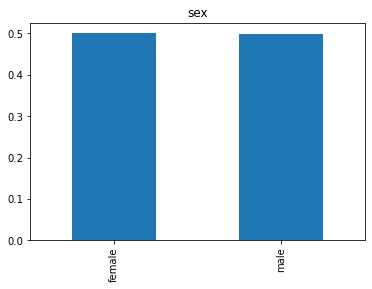

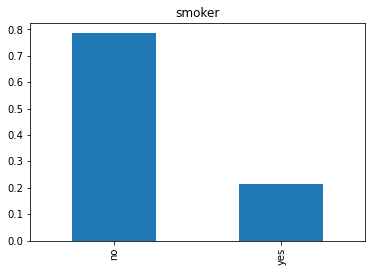

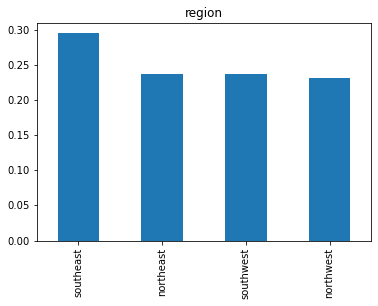

In [12]:
import matplotlib.pyplot as plt
for column in numerical_discrete + categorical:
    (df_insuarance[column].value_counts()/df_insuarance[column].shape[0]).plot(kind = 'bar')
    plt.title(column)
    plt.show()

In [13]:
df_insuarance['children'] = df_insuarance['children'].replace([3, 4, 5], 'Rare')

In [14]:
#mode
#mean
#median

encoded_features = {}
for column in numerical_discrete + categorical:
    encoded_features[column] = df_insuarance.groupby([column])['charges'].median().to_dict()
    df_insuarance[column] = df_insuarance[column].map(encoded_features[column])

In [15]:
encoded_features

{'children': {0: 9644.2525, 1: 8539.671, 2: 9954.0544, 'Rare': 10977.2063},
 'sex': {'female': 9639.395250000001, 'male': 9391.346},
 'smoker': {'no': 7345.4053, 'yes': 29330.98315},
 'region': {'northeast': 9661.16525,
  'northwest': 9301.89355,
  'southeast': 9768.88825,
  'southwest': 9328.071499999998}}

In [16]:
X = df_insuarance.drop('charges', axis = 1)
y = df_insuarance['charges']

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(model, 5)
X_rfe = rfe.fit_transform(X, y)  
model.fit(X_rfe, y)
print(pd.Series(rfe.support_, index = X.columns))

age          True
sex          True
bmi          True
children    False
smoker       True
region       True
dtype: bool


The column *children* had to be dropped according to the RFE. This could have been as a result of the combined rare levels analysis that could have compromised the integrity of the feature.

## Assignment 8

In [18]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.utils.fixes import parse_version

In [19]:
X, y = make_regression(n_samples=10000, noise=100, random_state=0)
y = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

Log is used for two reasons:
1. Optimizing the log prevents numerical instability of the model
2. OPtimizes the same original function. The value you optimize for will not be the same, but the parameters that achieve the optimum will.

In [20]:
df_a = df_insuarance

In [21]:
df_b = df_insuarance

In [22]:
#Pre-requisite: train test split to avoid data leakage

x_a = df_a.iloc[:, 1:-1]
y_a = df_a.iloc[:, -1]

from sklearn.model_selection import train_test_split

x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a, y_a, test_size=0.3, random_state=1)

In [23]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

le = LabelEncoder()
sex_le = le.fit_transform(x_a_train.sex)

#Apply to x_train and x_test

x_a_train.loc[:, 'sex'] = le.fit_transform(x_a_train.loc[:, 'sex'])
x_a_train.loc[:, 'smoker'] = le.fit_transform(x_a_train.loc[:, 'smoker'])
x_a_train.loc[:, 'region'] = le.fit_transform(x_a_train.loc[:, 'region'])

x_a_test.loc[:, 'sex'] = le.fit_transform(x_a_test.loc[:, 'sex'])
x_a_test.loc[:, 'smoker'] = le.fit_transform(x_a_test.loc[:, 'smoker'])
x_a_test.loc[:, 'region'] = le.fit_transform(x_a_test.loc[:, 'region'])

In [24]:
x_b = df_b.iloc[:, 1:-1]
y_b = df_b.iloc[:, -1]

from sklearn.model_selection import train_test_split

x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b, y_b, test_size=0.3, random_state=1)

In [26]:
y_b_train = pd.to_numeric(y_b_train)
y_b_test = pd.to_numeric(y_b_test)

from category_encoders import TargetEncoder

te = TargetEncoder()

def target_encoder(col, target):
    for i in range(len(x_b_train.columns)):
        col.iloc[:,i] = te.fit_transform(col, target)
    return col

df_te_train = target_encoder(x_b_train, y_b_train)
df_te_train.head()

,sex,bmi,children,smoker,region
1007,9391.34600,9391.34600,9391.34600,9391.34600,9391.34600
69,9391.34600,9391.34600,9391.34600,9391.34600,9391.34600
764,9639.39525,9639.39525,9639.39525,9639.39525,9639.39525
832,9639.39525,9639.39525,9639.39525,9639.39525,9639.39525
999,9639.39525,9639.39525,9639.39525,9639.39525,9639.39525


In [27]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

x_a_train_ss = pd.DataFrame(StandardScaler().fit_transform(x_a_train), columns=x_a_train.columns)
x_a_train_ss.head()

,sex,bmi,children,smoker,region
0,-1.004428,-0.334821,1.879638,1.919051,-1.350550
1,-1.004428,-0.920196,1.879638,1.919051,1.292169
2,0.995591,-0.755019,0.479116,-0.521091,0.411263
3,0.995591,-0.938856,0.479116,-0.521091,-1.350550
4,0.995591,-0.518658,0.055050,-0.521091,-1.350550


In [28]:
x_a_train_rs = pd.DataFrame(RobustScaler().fit_transform(x_a_train), columns=x_a_train.columns)
x_a_train_rs.head()

,sex,bmi,children,smoker,region
0,-1.0,0.000000,4.3026,1.0,-1.0
1,-1.0,-0.363675,4.3026,1.0,0.5
2,0.0,-0.261056,1.0000,0.0,0.0
3,0.0,-0.375268,1.0000,0.0,-1.0
4,0.0,-0.114212,0.0000,0.0,-1.0


In [29]:
x_a_train_mm = pd.DataFrame(MinMaxScaler().fit_transform(x_a_train), columns=x_a_train.columns)
x_a_train_mm.head()

,sex,bmi,children,smoker,region
0,0.0,0.329701,1.000000,1.0,0.000000
1,0.0,0.215765,1.000000,1.0,1.000000
2,1.0,0.247915,0.580251,0.0,0.666667
3,1.0,0.212133,0.580251,0.0,0.000000
4,1.0,0.293920,0.453155,0.0,0.000000


In [30]:
x_a_test_rs = pd.DataFrame(RobustScaler().fit_transform(x_a_test), columns=x_a_test.columns)

In [31]:
x_b_train_rs = pd.DataFrame(RobustScaler().fit_transform(x_b_train), columns=x_b_train.columns)
x_b_test_rs = pd.DataFrame(RobustScaler().fit_transform(x_b_test), columns=x_b_test.columns)

In [40]:
df_a_train_processed = pd.concat([x_a_train_rs_over, y_a_train_over], axis=1) #combine processed features with their target

cm_a = df_a_train_processed.corr()

print(cm_a.target.sort_values().tail(10))

plt.figure(figsize=(20,20))
sns.heatmap(cm_a, xticklabels=df_a_train_processed.columns, yticklabels=df_a_train_processed.columns,annot=True)

NameError: name 'x_a_train_rs_over' is not defined

In [39]:
df_a_train_processed.shape

from sklearn.decomposition import PCA

pca = PCA(.95)

pca_a_train = pca.fit(x_a_train_rs_over, y_a_train_over)
print(pca_a_train.n_components_)

plt.plot(np.cumsum(pca_a_train.explained_variance_ratio_))
plt.show()

x_a_train_rs_over_pca = pd.DataFrame(pca_a_train.transform(x_a_train_rs_over))
x_a_train_rs_over_pca.head()

NameError: name 'df_a_train_processed' is not defined

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [37]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "SVC" : SVC(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier()
}

In [38]:
train_scores = []
test_scores = []

for key, classifier in classifiers.items():
    classifier.fit(x_a_train_rs_over_pca, y_a_train_over)
    train_score = round(classifier.score(x_a_train_rs_over_pca, y_a_train_over),2)
    train_scores.append(train_score)
    test_score = round(classifier.score(x_a_test_rs_over_pca, y_a_test_over),2)
    test_scores.append(test_score)

print(train_scores)
print(test_scores)

NameError: name 'x_a_train_rs_over_pca' is not defined